# Install libraries

In [8]:
!pip install thop

# Imports

In [9]:
from typing import Optional
import os
import time

import torch
from torch import nn
from torchaudio import functional as F_audio
from torch.nn import functional as F
import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS

from torch.utils.data import DataLoader, Subset, Dataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import numpy as np
from thop import profile

In [10]:
class LogMelFilterBanks(nn.Module):
    def __init__(
            self,
            n_fft: int = 400,
            samplerate: int = 16000,
            hop_length: int = 160,
            n_mels: int = 80,
            pad_mode: str = 'reflect',
            power: float = 2.0,
            normalize_stft: bool = False,
            onesided: bool = True,
            center: bool = True,
            return_complex: bool = True,
            f_min_hz: float = 0.0,
            f_max_hz: Optional[float] = None,
            norm_mel: Optional[str] = None,
            mel_scale: str = 'htk'
        ):
        super(LogMelFilterBanks, self).__init__()
        self.n_fft = n_fft
        self.samplerate = samplerate
        self.window_length = n_fft
        
        # Initialize STFT parameters
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.center = center
        self.return_complex = return_complex
        self.onesided = onesided
        self.normalize_stft = normalize_stft
        self.pad_mode = pad_mode
        self.power = power

        # Initialize mel filterbank parameters
        self.f_min_hz = f_min_hz
        self.f_max_hz = f_max_hz if f_max_hz is not None else samplerate / 2
        self.norm_mel = norm_mel
        self.mel_scale = mel_scale

        # Initialize mel filterbanks
        self.mel_fbanks = self._init_melscale_fbanks()

    def _init_melscale_fbanks(self):
        # For onesided STFT, we need n_fft//2 + 1 frequency bins
        n_freqs = self.n_fft // 2 + 1 if self.onesided else self.n_fft
        return F_audio.melscale_fbanks(
            n_freqs=n_freqs,
            f_min=self.f_min_hz,
            f_max=self.f_max_hz,
            n_mels=self.n_mels,
            sample_rate=self.samplerate,
            norm=self.norm_mel,
            mel_scale=self.mel_scale
        )

    def spectrogram(self, x):
        if x.dim() == 3:  
            x = x.squeeze(1) 
        
        window = torch.hann_window(self.window_length, device=x.device)
        
        # Compute STFT
        spec = torch.stft(
            x,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.window_length,
            window=window,
            center=self.center,
            pad_mode=self.pad_mode,
            normalized=self.normalize_stft,
            onesided=self.onesided,
            return_complex=self.return_complex
        )
        return spec

    def forward(self, x):
        """
        Args:
            x (Torch.Tensor): Tensor of audio of dimension (batch, time) or (batch, channel, time)
        Returns:
            Torch.Tensor: Tensor of log mel filterbanks of dimension (batch, n_mels, n_frames),
                where n_frames is a function of the window_length, hop_length and length of audio
        """
        # Compute spectrogram
        spec = self.spectrogram(x)
        
        # Convert to power spectrogram if complex
        if self.return_complex:
            spec = torch.abs(spec) ** self.power
        else:
            spec = spec ** self.power
            
        # Apply mel filterbanks
        # Transpose spec to match dimensions for matmul
        spec = spec.transpose(-1, -2)  # [batch, time, freq]
        mel_spec = torch.matmul(spec, self.mel_fbanks.to(x.device))  # [batch, time, n_mels]
        mel_spec = mel_spec.transpose(-1, -2)  # [batch, n_mels, time]
        
        return torch.log(mel_spec + 1e-6)


# Model

In [11]:
class SpeechCommandModel(pl.LightningModule):
    def __init__(self, n_mels=80, groups=1):
        super().__init__()
        self.save_hyperparameters()
        
        # Feature extraction
        self.feature_extractor = LogMelFilterBanks(n_mels=n_mels)
        
        # CNN layers with batch normalization
        self.conv1 = nn.Conv1d(n_mels, 32, kernel_size=3, groups=groups)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, groups=groups)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, groups=groups)
        self.bn3 = nn.BatchNorm1d(128)
        
        # Pooling and dropout
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 1)  # Binary classification
        
        # Calculate number of parameters and FLOPs
        self.nparams, self.flops = self.calculate_complexity()
    
    def calculate_complexity(self):
        # Create a dummy input
        dummy_input = torch.randn(1, 1, 16000)  # 1 second of audio at 16kHz
        # Calculate FLOPs and parameters
        flops, params = profile(self, inputs=(dummy_input,))
        print(f"Model complexity:")
        print(f"Parameters: {params:,}")
        print(f"FLOPs: {flops:,}")
        return params, flops
    
    def forward(self, x):
        # Extract features
        x = self.feature_extractor(x)
        
        # CNN layers with ReLU and batch norm
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.max_pool1d(x, 2)
        
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = F.max_pool1d(x, 2)
        
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.max_pool1d(x, 2)
        
        # Global average pooling
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        
        return x.squeeze(-1)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy(y_hat, y.float())
        self.log('train_loss', loss, prog_bar=True, sync_dist=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy(y_hat, y.float())
        accuracy = ((y_hat > 0.5) == y).float().mean()
        self.log('val_loss', loss, prog_bar=True, sync_dist=True)
        self.log('val_accuracy', accuracy, prog_bar=True, sync_dist=True)
        return loss, accuracy
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy(y_hat, y.float())
        accuracy = ((y_hat > 0.5) == y).float().mean()
        self.log('test_loss', loss, prog_bar=True, sync_dist=True)
        self.log('test_accuracy', accuracy, prog_bar=True, sync_dist=True)
        return loss, accuracy
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='max', 
            factor=0.5, 
            patience=2, 
            verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_accuracy",
                "frequency": 1
            }
        }

# Prepare data function

In [12]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./data", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj if line.split("/")[0] in ["yes", "no"]]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


class YesNoDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.indices = [i for i, (_, _, label, *_) in enumerate(dataset) if label in ["yes", "no"]]
        self.labels = [1 if dataset[i][2] == "yes" else 0 for i in self.indices]
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        waveform, *_ = self.dataset[self.indices[idx]]
        return waveform, self.labels[idx]


def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
    tensors, targets = [], []

    for waveform, label in batch:
        tensors += [waveform]
        targets += [label]

    tensors = pad_sequence(tensors)
    targets = torch.tensor(targets)

    return tensors, targets



def prepare_data(batch_size=32, num_workers=4, pin_memory=True):
    os.makedirs("data", exist_ok=True)

    train_dataset = SubsetSC("training")
    val_dataset = SubsetSC("validation")
    test_dataset = SubsetSC("testing")

    train_dataset = YesNoDataset(train_dataset)
    val_dataset = YesNoDataset(val_dataset)
    test_dataset = YesNoDataset(test_dataset)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        collate_fn=collate_fn,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        collate_fn=collate_fn,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )
    return train_loader, val_loader, test_loader



In [13]:
num_workers = 3
pin_memory = True
batch_size = 512
train_loader, val_loader, test_loader = prepare_data(batch_size, num_workers, pin_memory)

In [14]:
pl.seed_everything(42)

42

In [15]:
n_mels_values = [20, 80]
groups_values = [2, 4]


useful_info = []

for n_mels in n_mels_values:
    for groups in groups_values:
        print(f"\nTraining model with n_mels={n_mels}, groups={groups}")
        
        model = SpeechCommandModel(n_mels=n_mels, groups=groups)

        nparams, flops = model.nparams, model.flops
        
        trainer = pl.Trainer(
            max_epochs=20,
            accelerator='gpu' if torch.cuda.is_available() else 'cpu',
            devices=1,
            callbacks=[
                ModelCheckpoint(
                    monitor='val_accuracy',
                    mode='max',
                    save_top_k=1,
                    filename=f'model-mels{n_mels}-groups{groups}-{{epoch:02d}}-{{val_accuracy:.2f}}'
                ),
                pl.callbacks.EarlyStopping(
                    monitor='val_accuracy',
                    mode='max',
                    patience=3,
                    min_delta=0.001
                ),
                pl.callbacks.LearningRateMonitor(logging_interval='epoch')
            ],
            enable_checkpointing=True,
            enable_progress_bar=True,
            enable_model_summary=True,
            logger=pl.loggers.CSVLogger(
                "logs", 
                name=f"model_mels{n_mels}_groups{groups}"
            )
        )
        
        start_time = time.time()
        fit_results = trainer.fit(model, train_loader, val_loader)
        total_time = time.time() - start_time
        
        num_epochs = trainer.current_epoch + 1
        avg_epoch_time = total_time / num_epochs
        
        trainer.logger.log_metrics({
            'total_training_time': total_time,
            'num_epochs': num_epochs,
            'avg_epoch_time': avg_epoch_time
        })
        
        test_results = trainer.test(model, test_loader)
        
        print(f"Completed training for n_mels={n_mels}, groups={groups}")
        print(f"Total training time: {total_time:.2f}s")
        print(f"Average epoch time: {avg_epoch_time:.2f}s")

        config_info = {
            "n_params": nparams,
            "flops": flops,
            "total_epochs": num_epochs,
            "total_time": total_time,
            "mels": n_mels,
            "groups": groups,
            "test_accuracy": test_results[0]["test_accuracy"],
        }
        useful_info.append(config_info)

print("\nAll experiments completed!")


Training model with n_mels=20, groups=2
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Model complexity:
Parameters: 25,313.0
FLOPs: 542,592.0


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9708737730979919     │
│         test_loss         │    0.08216652274131775    │
└───────────────────────────┴───────────────────────────┘

Completed training for n_mels=20, groups=2
Total training time: 150.88s
Average epoch time: 10.78s

Training model with n_mels=20, groups=4
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Model complexity:
Parameters: 17,153.0
FLOPs: 293,856.0


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.981796145439148     │
│         test_loss         │    0.05540421977639198    │
└───────────────────────────┴───────────────────────────┘

Completed training for n_mels=20, groups=4
Total training time: 217.34s
Average epoch time: 10.87s

Training model with n_mels=80, groups=2
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Model complexity:
Parameters: 28,193.0
FLOPs: 827,712.0


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9733009934425354     │
│         test_loss         │    0.09002923220396042    │
└───────────────────────────┴───────────────────────────┘

Completed training for n_mels=80, groups=2
Total training time: 169.52s
Average epoch time: 10.59s

Training model with n_mels=80, groups=4
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Model complexity:
Parameters: 18,593.0
FLOPs: 436,416.0


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9623786211013794     │
│         test_loss         │    0.10702753812074661    │
└───────────────────────────┴───────────────────────────┘

Completed training for n_mels=80, groups=4
Total training time: 158.64s
Average epoch time: 10.58s

All experiments completed!


# Анализ результатов

In [18]:
import pandas as pd


useful_info = pd.DataFrame(useful_info)
useful_info.to_csv("useful_info.csv")

In [31]:
useful_info

,n_params,flops,total_epochs,total_time,mels,groups,test_accuracy,avg_epoch_time
0,25313.0,542592.0,14,150.875113,20,2,0.970874,10.776794
1,17153.0,293856.0,20,217.342015,20,4,0.981796,10.867101
2,28193.0,827712.0,16,169.516603,80,2,0.973301,10.594788
3,18593.0,436416.0,15,158.640696,80,4,0.962379,10.576046


<ipython-input-29-a7b4fd7bab9e>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


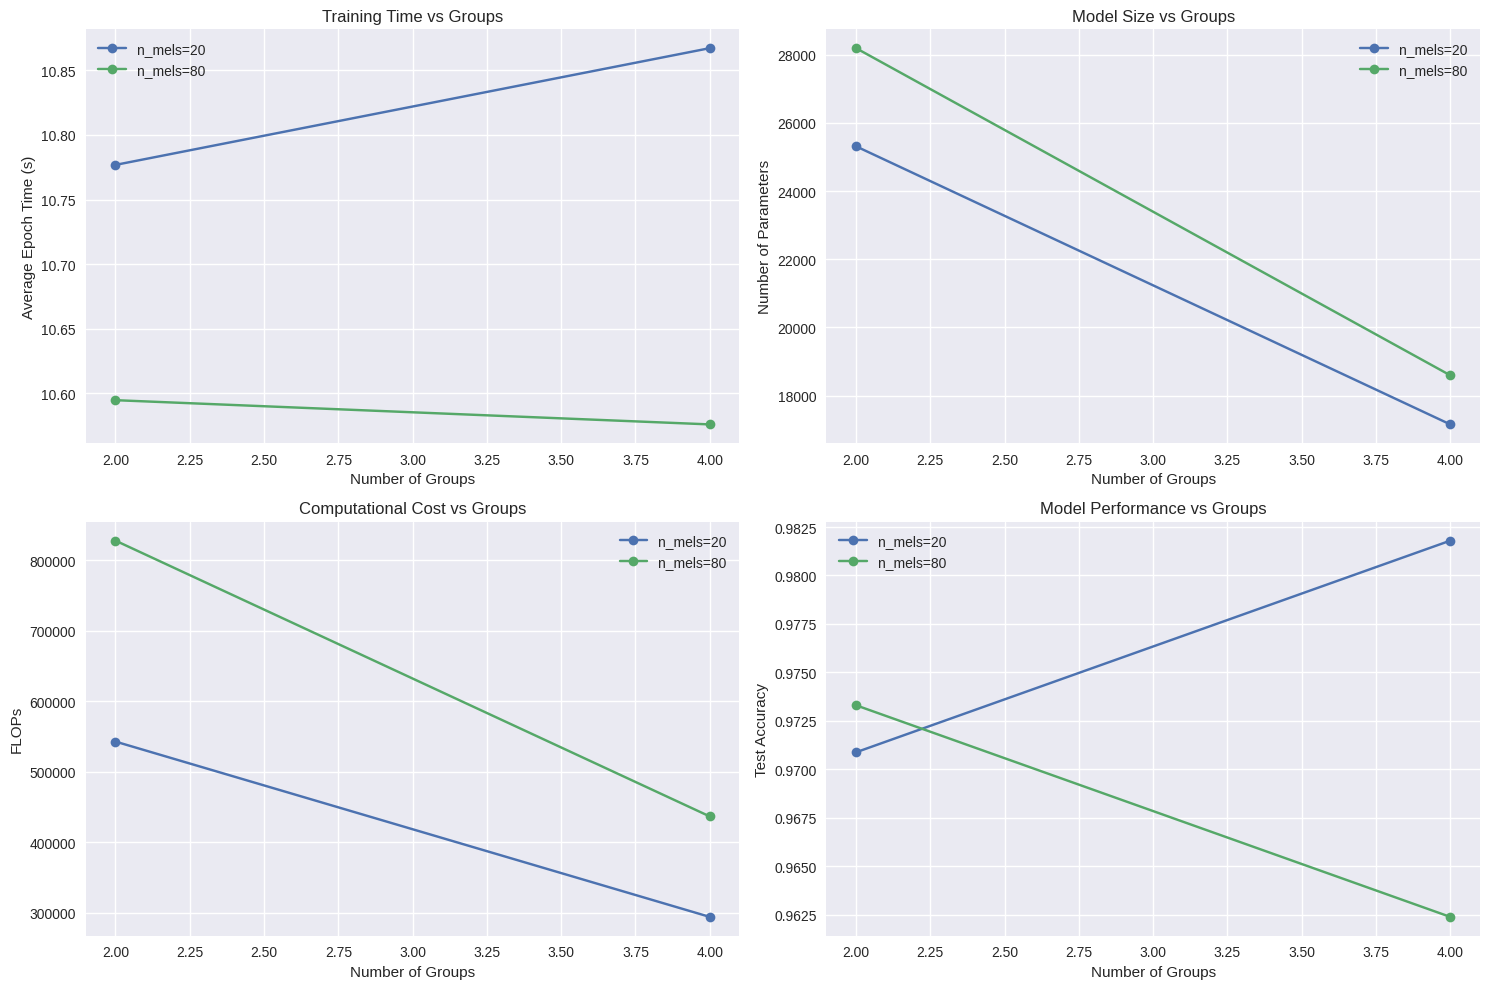


Experiment Results Summary:
             test_accuracy  avg_epoch_time  n_params     flops
mels groups                                                   
20   2              0.9709         10.7768   25313.0  542592.0
     4              0.9818         10.8671   17153.0  293856.0
80   2              0.9733         10.5948   28193.0  827712.0
     4              0.9624         10.5760   18593.0  436416.0

Detailed summary saved to 'group_convolution_summary.csv'


In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


df = useful_info

df['avg_epoch_time'] = df['total_time'] / df['total_epochs']

plt.style.use('seaborn')
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2)

# Plot 1: Epoch training time vs groups
ax1 = fig.add_subplot(gs[0, 0])
for mels in df['mels'].unique():
    data = df[df['mels'] == mels]
    ax1.plot(data['groups'], data['avg_epoch_time'], 
             marker='o', label=f'n_mels={mels}')
ax1.set_xlabel('Number of Groups')
ax1.set_ylabel('Average Epoch Time (s)')
ax1.set_title('Training Time vs Groups')
ax1.legend()
ax1.grid(True)

# Plot 2: Number of parameters vs groups
ax2 = fig.add_subplot(gs[0, 1])
for mels in df['mels'].unique():
    data = df[df['mels'] == mels]
    ax2.plot(data['groups'], data['n_params'], 
             marker='o', label=f'n_mels={mels}')
ax2.set_xlabel('Number of Groups')
ax2.set_ylabel('Number of Parameters')
ax2.set_title('Model Size vs Groups')
ax2.legend()
ax2.grid(True)

# Plot 3: FLOPs vs groups
ax3 = fig.add_subplot(gs[1, 0])
for mels in df['mels'].unique():
    data = df[df['mels'] == mels]
    ax3.plot(data['groups'], data['flops'], 
             marker='o', label=f'n_mels={mels}')
ax3.set_xlabel('Number of Groups')
ax3.set_ylabel('FLOPs')
ax3.set_title('Computational Cost vs Groups')
ax3.legend()
ax3.grid(True)

# Plot 4: Test accuracy vs groups
ax4 = fig.add_subplot(gs[1, 1])
for mels in df['mels'].unique():
    data = df[df['mels'] == mels]
    ax4.plot(data['groups'], data['test_accuracy'], 
             marker='o', label=f'n_mels={mels}')
ax4.set_xlabel('Number of Groups')
ax4.set_ylabel('Test Accuracy')
ax4.set_title('Model Performance vs Groups')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()
# plt.savefig('group_convolution_analysis.png', dpi=300, bbox_inches='tight')
# plt.close()

print("\nExperiment Results Summary:")
summary = df.groupby(['mels', 'groups']).agg({
    'test_accuracy': 'mean',
    'avg_epoch_time': 'mean',
    'n_params': 'mean',
    'flops': 'mean'
}).round(4)
print(summary)

summary.to_csv('group_convolution_summary.csv')
print("\nDetailed summary saved to 'group_convolution_summary.csv'") 

# Выводы:
* При увеличении параметра groups с 2 до 4 число FLOPS ~ в 2 раза меньше и параметров тоже меньше, но не в 2 раза, а где-то на четверть.
* Время одной эпохи обучения во всех конфигурациях одинаковое примерно.
* Чем больше n_mels, тем больше параметров, но не сильно в моем примере.
* С точки зрения метрик - лучшй показатель при mels=20, groups=4. Но в целом, +- одинаковые у всех. Может быть слишком сложную модель сделал и разницу видно не так четко. 
